# Bike Crash Severity Modelling for San Francisco
## Introduction
In this section we develop models guided by insights from the exploratory data analysis. Our goal is to identify the factors that most strongly predict cyclist injury severity in San Francisco. This differs from studies such as Scarano et al. (2023), which use national datasets and more advanced modeling frameworks; our work applies similar count and severity models to San Francisco’s TIMS bicycle crash data. This is useful because a city-level analysis captures local patterns and street conditions that broader national studies cannot reflect. Although TIMS data are pre-processed and standardized, additional cleaning and filtering were required to obtain a consistent set of San Francisco bicycle crashes suitable for modeling.

## Crash Severity Categories
The data considers four crash severities. The outcome of this kind of statistical modelling is highly dependent on the proportion of data available for each crash severity. In our dataset, the distribution of crash severities is as follows: Fatal (0.5%), Severe Injury (9.5%), Other Visible Injury (44.4%), and Complaint of Pain (45.7%). Given the low proportion of fatal crashes, we combine Fatal and Severe Injury into a single category called "Severe Injury" and combined the other categories into "Other Injury". This results in two categories: Killed or Severely Injured (10%) and Other Injury (90%).

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Importing custom data cleaning functions
from tools.data_cleaning import*

# Importing packages needed for the different models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Importing packages needed for Interpretation
import shap

In [31]:
# Importing the data
crashes = clean_crashes("data/Crashes.csv")
parties = clean_parties("data/Parties.csv")
victims = clean_victims("data/Victims.csv")
victim_level = build_victim_level_table("data") # This combines and cleans all three datasets

In [48]:
# Creating a summary table for proportions of different severity crashes

# Mapping the different severity levels to their descriptions
severity_labels = {
    1: "Fatal",
    2: "Severe injury",
    3: "Other visible injury",
    4: "Complaint of pain",
}

crashes["Crash severity"] = crashes["COLLISION_SEVERITY"].map(severity_labels)

# Counting the number of crashes for each severity level
counts = crashes["Crash severity"].value_counts()
total = counts.sum()

# Populating the table
table = pd.DataFrame(
    {
        "Crash severity": counts.index,
        "Number of events": counts.values,
        "Percent of total": (counts / total * 100).round(1),
    }
)
table.loc[len(table)] = ["Total", total, 100.0]

# Saving the table as a CSV file
table.to_csv("figures/crash_severity_summary.csv", index=False)

# Defining the table style
display(table.style.hide(axis="index").format({"Number of events": "{:,}", "Percent of total": "{:.1f}%"}))

Crash severity,Number of events,Percent of total
Complaint of pain,"2,277",45.7%
Other visible injury,"2,212",44.4%
Severe injury,474,9.5%
Fatal,23,0.5%
Total,"4,986",100.0%


In [49]:
# Creating a summary table for proportions of different severity crashes
# Consider fatal and severe injury to be KSI (killed or severely injured)

severity_to_group = {
    1: "KSI",   # fatal
    2: "KSI",   # severe injury
    3: "Other injury",
    4: "Other injury",
}
crashes["severity_group"] = crashes["COLLISION_SEVERITY"].map(severity_to_group)

counts = crashes["severity_group"].value_counts().reindex(["KSI", "Other injury"], fill_value=0)
total = counts.sum()

# Populating the table
table = pd.DataFrame(
    {
        "Severity group": counts.index,
        "Number of events": counts.values,
        "Percent of total": (counts / total * 100).round(1),
    }
)
table.loc[len(table)] = ["Total", total, 100.0]

# Saving the table as a CSV file
table.to_csv("figures/KSI_crash_severity_summary.csv", index=False)

# Defining the table style
display(table.style.hide(axis="index").format({"Number of events": "{:,}", "Percent of total": "{:.1f}%"}))



Severity group,Number of events,Percent of total
KSI,497,10.0%
Other injury,"4,489",90.0%
Total,"4,986",100.0%


## Crash Severity Models
Three classification models: 1) multinomial logit model, 2) random forest, and 3) XGBoost, were used to predict the severity of cyclist injuries in crashes. Reference was made to the research by {cite}`Scarano2023`. The models estimate the probability of Killed or Severely Injured (KSI) or Other injury based on various predictor variables such as road conditions, weather, time of day, cyclist demographics, etc. To determine which parameters to use in the models, we looked at the different variables and removed variables which are nearly constant (low variance). 

Since the number of observations in the "Killed and Severely Injured (KSI)" category is very low compared to the "Other injury" category, for each of the models, we applied some form of class balancing such that the loss allocation across the different categories was approximately equal. The balancing scheme was chosen in a way that maximized the precision (PR) AUC value of each model.

Additionally, in order to determine the best model, we compared their performance using metrics such as accuracy, precision, recall, and F1-score. The model with the highest performance metrics was selected as the best model for predicting severity in San Francisco bike crashes.

In [34]:
# Preparing data for modeling

# Importing crashed data
crashes = clean_crashes("data/Crashes.csv")

# Creating the target variable ( KSI (killed or severely injured) and Other injury)
severity_to_group = {1: "KSI", 2: "KSI", 3: "Other injury", 4: "Other injury"}
crashes["target_ksi"] = crashes["COLLISION_SEVERITY"].map(severity_to_group).eq("KSI").astype(int)

# Selecting features and target variable
cols = [
    "ACCIDENT_YEAR", "COLLISION_TIME", "REPORTING_DISTRICT",
    "PRIMARY_RD", "SECONDARY_RD", "INTERSECTION",
    "WEATHER_1", "PRIMARY_COLL_FACTOR", "HIT_AND_RUN",
    "TYPE_OF_COLLISION", "MVIW", "ROAD_SURFACE", "ROAD_COND_1", "LIGHTING",
    "PEDESTRIAN_ACCIDENT", "MOTORCYCLE_ACCIDENT", "TRUCK_ACCIDENT",
    "ALCOHOL_INVOLVED", "STWD_VEHTYPE_AT_FAULT", "CHP_VEHTYPE_AT_FAULT",
]
X = crashes[cols].copy().replace({pd.NA: np.nan})  # remove pd.NA
y = crashes["target_ksi"]

# Identifying column types
cat_cols = [c for c in cols if X[c].dtype == "object"]
bool_cols = [c for c in cols if str(X[c].dtype) == "boolean"]
num_cols = [c for c in cols if c not in cat_cols + bool_cols]

# Defining data types for each column type
X[cat_cols] = X[cat_cols].astype("object")
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors="coerce")
X[bool_cols] = X[bool_cols].astype(float)

# Creating preprocessing pipelines for both numeric and categorical data
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

preproc = ColumnTransformer([
    ("cat", cat_pipe, cat_cols),
    ("num", num_pipe, num_cols + bool_cols),
])


### Multinomial Logit Model
We trained a class-balanced logistic regression using an 80-20 test-train split. The random seed of the split was fixed to ensure reproducibility.

In [35]:
# Logistic Regression classifier with balanced class weights
# Setting up the classifier and pipeline
clf = LogisticRegression(solver="lbfgs", max_iter=500, class_weight="balanced")
pipe = Pipeline([("preproc", preproc), ("clf", clf)])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Fitting the model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

# Capturing model metrics
logit_report = classification_report(y_test, y_pred, output_dict=True)
logit_roc_auc = roc_auc_score(y_test, y_prob)
logit_pr_auc = average_precision_score(y_test, y_prob)

# Print
print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", logit_roc_auc)
print("PR AUC :", logit_pr_auc)


              precision    recall  f1-score   support

           0      0.919     0.710     0.801       899
           1      0.141     0.434     0.213        99

    accuracy                          0.682       998
   macro avg      0.530     0.572     0.507       998
weighted avg      0.842     0.682     0.743       998

ROC AUC: 0.5718812148178111
PR AUC : 0.1665541992106315


### Random Forest Model
We trained a class-balanced random forest (RF) model using the same 80-20 test-train split and random seed as the logistic regression model. We tried a small set of hyperparameter configurations (varying tree count and depth) and found that PR AUC plateaued with negligible gains. For this reason, we kept a simple, class-balanced RF model with fixed hyperparameters.

In [36]:
# Random Forest classifier with balanced class weights

# Setting up the Random Forest classifier and pipeline
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)
rf_pipe = Pipeline([("preproc", preproc), ("clf", rf_clf)])

# Fitting the Random Forest model
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

# Capturing model metrics
rf_report = classification_report(y_test, y_pred, output_dict=True)
rf_roc_auc = roc_auc_score(y_test, y_prob)
rf_pr_auc = average_precision_score(y_test, y_prob)

print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC :", average_precision_score(y_test, y_prob))


              precision    recall  f1-score   support

           0      0.922     0.727     0.813       899
           1      0.152     0.444     0.227        99

    accuracy                          0.699       998
   macro avg      0.537     0.586     0.520       998
weighted avg      0.846     0.699     0.755       998

ROC AUC: 0.6204424669385739
PR AUC : 0.1563570430406871


### XGBoost Model
We fit an XGBoost classifier with class imbalance handled using scale_pos_weight, using the same 80/20 stratified split and random seed. A quick trial of different tree counts, depths, and learning rates showed PR AUC changes were negligible, so we kept a simple, class-balanced XGBoost configuration with fixed hyperparameters. Additionally, we found that a scale_pos_weight of 0.5 times the weight that balances the classes maximized PR AUC.

In [37]:
# XGBoost classifier with scale_pos_weight to address class imbalance

# class imbalance ratio
scale_pos = (y == 0).sum() / (y == 1).sum()

xgb_clf = XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=0.5*scale_pos,
    random_state=42,
    n_jobs=-1,
)

xgb_pipe = Pipeline([("preproc", preproc), ("clf", xgb_clf)])

xgb_pipe.fit(X_train, y_train)
y_pred = xgb_pipe.predict(X_test)
y_prob = xgb_pipe.predict_proba(X_test)[:, 1]

xgb_report = classification_report(y_test, y_pred, output_dict=True)
xgb_roc_auc = roc_auc_score(y_test, y_prob)
xgb_pr_auc  = average_precision_score(y_test, y_prob)

print(classification_report(y_test, y_pred, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC :", average_precision_score(y_test, y_prob))


              precision    recall  f1-score   support

           0      0.909     0.945     0.927       899
           1      0.222     0.141     0.173        99

    accuracy                          0.866       998
   macro avg      0.566     0.543     0.550       998
weighted avg      0.841     0.866     0.852       998

ROC AUC: 0.6189368658779115
PR AUC : 0.1678465735734489


In [45]:
# Detailed results table for each model and class
rows = []
for model, roc, pr, rep in [
    ("Multinomial Logit", logit_roc_auc, logit_pr_auc, logit_report),
    ("Random Forest",     rf_roc_auc,    rf_pr_auc,    rf_report),
    ("XGBOOST",           xgb_roc_auc,   xgb_pr_auc,   xgb_report),
]:
    rows.append({"Model": model, "Class": "Other Injury",
                 "ROC AUC": roc, "PR AUC": pr,
                 "Precision": rep["0"]["precision"],
                 "Recall": rep["0"]["recall"],
                 "F1-score": rep["0"]["f1-score"]})
    rows.append({"Model": model, "Class": "KSI",
                 "ROC AUC": roc, "PR AUC": pr,
                 "Precision": rep["1"]["precision"],
                 "Recall": rep["1"]["recall"],
                 "F1-score": rep["1"]["f1-score"]})

table = pd.DataFrame(rows)

# Blank duplicates for display
mask = table["Model"].duplicated()
table_display = table.copy()
table_display.loc[mask, "Model"] = ""
table_display.loc[mask, ["ROC AUC", "PR AUC"]] = np.nan

# Ordering the columns: Model, ROC AUC, PR AUC, Class, Precision, Recall, F1-score
cols = ["Model", "ROC AUC", "PR AUC", "Class", "Precision", "Recall", "F1-score"]
table_display = table_display[cols]

# Saving the results table to a CSV file
table_display.to_csv("figures/model_summary.csv", index=False)

# Displaying the results table
display(
    table_display.style.hide(axis="index").format(
        formatter={
            "ROC AUC": "{:.3f}", "PR AUC": "{:.3f}",
            "Precision": "{:.3f}", "Recall": "{:.3f}", "F1-score": "{:.3f}"
        },
        na_rep=""
    )
)




Model,ROC AUC,PR AUC,Class,Precision,Recall,F1-score
Multinomial Logit,0.572,0.167,Other Injury,0.919,0.710,0.801
,,,KSI,0.141,0.434,0.213
Random Forest,0.620,0.156,Other Injury,0.922,0.727,0.813
,,,KSI,0.152,0.444,0.227
XGBOOST,0.619,0.168,Other Injury,0.909,0.945,0.927
,,,KSI,0.222,0.141,0.173


### Selecting the Best Crash Severity Model
Based on the performance metrics, we selected the Random Forest model as the best model since it has the best overall balance. This model has the top ROC AUC (0.620) and the highest KSI F1 and KSI recall values among the three models trained. XGBoost nas a slightly better PR AUC value than Random Forest (0.168 vs 0.156) however, it has much a lower KSI recall and F1 score. It also has the best model for predicting crash severity in San Francisco bike crashes. 

The Random Forest model was be used for further analysis and interpretation using SHAP (SHapley Additive exPlanations) to determine the most influential factors in the crash severity model ({cite}`shap`).

#### SHAP Analysis of the Random Forest Model
SHAP values were calculated for the Random Forest model to interpret the influence of each feature on the model's predictions. The SHAP summary plot shows the impact of each feature on the model output, with features ranked by their importance. The color of the points indicates the value of the feature (red for high values such as 1 for categorical features, blue for low values such as 0 for categorical features), and the position on the x-axis indicates the effect on the prediction (positive or negative impact on KSI probability). Since the primary and secondary road featires were dominating the SHAP plots, we separated them from the other features to better visualize the impact of the other features. For both the road and non-road features SHAP analysis, we created two plots, the SHAP beeswarm plot and the SHAP bar plot. The different categories were interpreted with reference to the TIMS SWITRS data codebook ({cite}`tims_switrs`).

In [39]:
# SHAP setup for the Random Forest
X_enc = preproc.transform(X_test)
feature_names = np.array(preproc.get_feature_names_out())
X_enc = X_enc.toarray() if hasattr(X_enc, "toarray") else np.asarray(X_enc)

explainer = shap.TreeExplainer(rf_pipe.named_steps["clf"])
raw = explainer.shap_values(X_enc)
if isinstance(raw, list):                        # list per class
    shap_array = np.asarray(raw[1])              # class 1 = KSI
else:                                            # Explanation/ndarray
    shap_array = raw.values if hasattr(raw, "values") else np.asarray(raw)
    if shap_array.ndim == 3:                     # (samples, features, outputs)
        shap_array = shap_array[:, :, 1]         # take class 1
shap_array = np.asarray(shap_array)              # (samples, n_features)

# Masks to split roads vs non-roads
road_mask = np.array([
    n.startswith("cat__PRIMARY_RD_") or n.startswith("cat__SECONDARY_RD_")
    for n in feature_names
])
other_mask = ~road_mask


In [40]:
# SHAP analysis for Random Forest model

# Encode test data and determining feature names
X_enc = preproc.transform(X_test)
feature_names = np.array(preproc.get_feature_names_out())
X_enc = X_enc.toarray() if hasattr(X_enc, "toarray") else np.asarray(X_enc)

# SHAP values for KSI class
explainer = shap.TreeExplainer(rf_pipe.named_steps["clf"])
raw = explainer.shap_values(X_enc)
if isinstance(raw, list):               # list per class
    shap_array = np.asarray(raw[1])
else:                                   # Explanation
    shap_array = raw.values if hasattr(raw, "values") else np.asarray(raw)
    if shap_array.ndim == 3:            # (samples, features, outputs)
        shap_array = shap_array[:, :, 1]  # take class 1 (KSI)
shap_array = np.asarray(shap_array)      # (samples, n_features)

# Masks to separate road vs non-road features
road_mask = np.array(
    [n.startswith("cat__PRIMARY_RD_") or n.startswith("cat__SECONDARY_RD_")
     for n in feature_names]
)
other_mask = ~road_mask



##### SHAP Analysis for Road Features
From the SHAP analysis of features relating to the road on which the crash occured i.e., "Primary_RD" and "Secondary_RD", we can see from the SHAP beeswarm and bar plots that some roads have a higher likelihood of KSI crashes. For example, crashes on Bayshore Boulevard, Balboa Street and Hill Street have a higher likelihood of being KSI crashes. On the other hand, crashs on Townsend Street, 18th Street adn California Street have a lower likelihood of being KSI crashes.

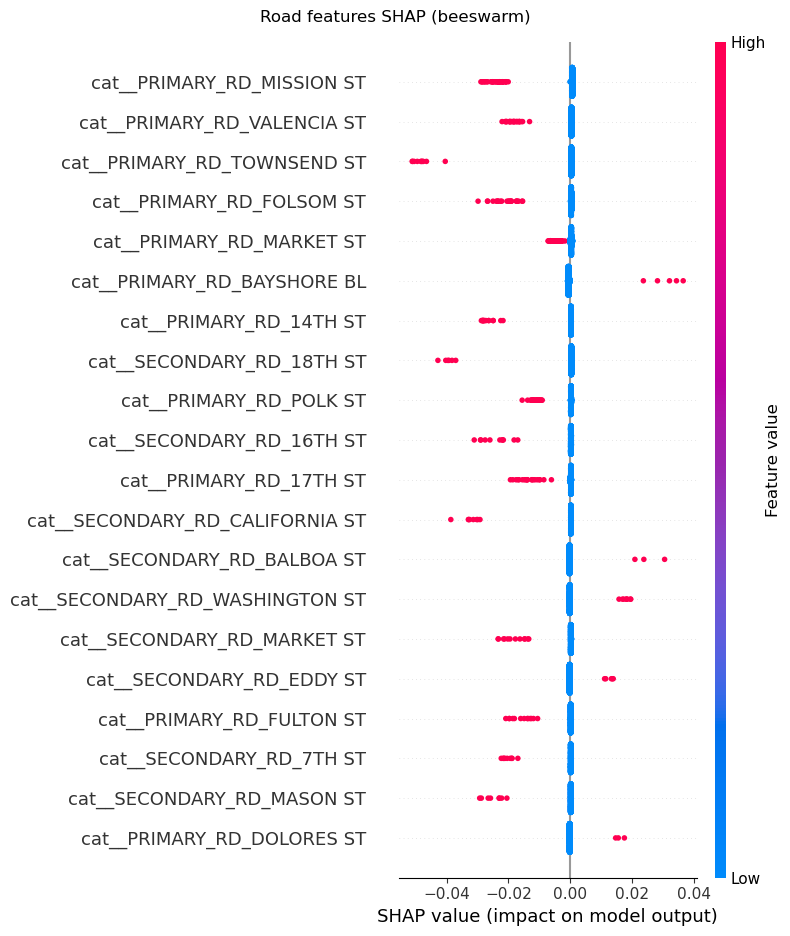

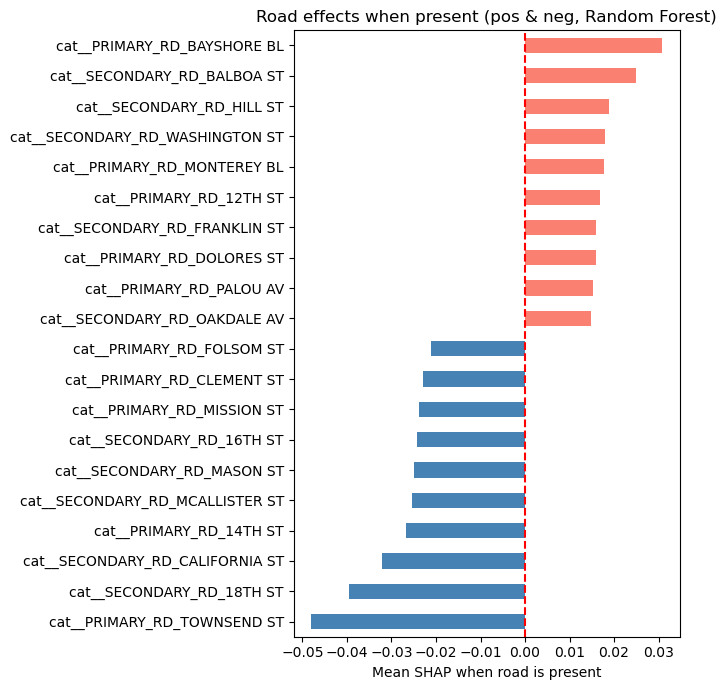

In [44]:
# SHAP summary plot for road features

shap.summary_plot(
    shap_array[:, road_mask],
    X_enc[:, road_mask],
    feature_names=feature_names[road_mask],
    max_display=20,
    show=False, 
)

fig = plt.gcf()
fig.suptitle("Road features SHAP (beeswarm)")
plt.tight_layout()

fig.savefig("figures/road_shap_beeswarm.png", dpi=300, bbox_inches="tight")

plt.show()
plt.close(fig)


# Conditional mean SHAP when the road dummy = 1
road_shap = shap_array[:, road_mask]
road_feat = X_enc[:, road_mask]
road_names = feature_names[road_mask]

present_mean = []
for j in range(road_shap.shape[1]):
    m = road_feat[:, j] == 1
    present_mean.append(road_shap[m, j].mean() if m.any() else 0.0)

present_series = pd.Series(present_mean, index=road_names)
top_pos = present_series.sort_values().tail(10)
top_neg = present_series.sort_values().head(10)
both = pd.concat([top_neg, top_pos])

# Bar plot
colors = ["steelblue" if v < 0 else "salmon" for v in both]
both.plot(kind="barh", figsize=(7,7), color=colors)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Mean SHAP when road is present")
plt.title("Road effects when present (pos & neg, Random Forest)")
plt.tight_layout()
plt.savefig("figures/road_effects_SHAP_bar.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()




##### SHAP Analysis for Non-Road Features
From the SHAP analysis of features not relating to the road on which the crash occured such as vehicle type at fault, lighting, type of collision, reporting district, collision type, accident year and weather, we can see from the SHAP beeswarm and bar plots that some categories or values have a higher likelihood of KSI crashes. For example, crashes from the traffic reporting district, those on road_condition_1_ D (construction or repair zone), those involving primary_collision_factor_C (other than driver), type_of_collision_F (overturned) and stwd_vehtype_at_fault_L (bicycle) have a higher likelihood of being KSI crashes. On the other hand, crashes where the vehicle type at fault is not the bicycle (is a bus, minivan, truck or sports utility vehicle), the weather is rainy (weather_1_C) or type of collision is a sideswipe(type_of_collision_B) have have a lower likelihood of being KSI crashes.

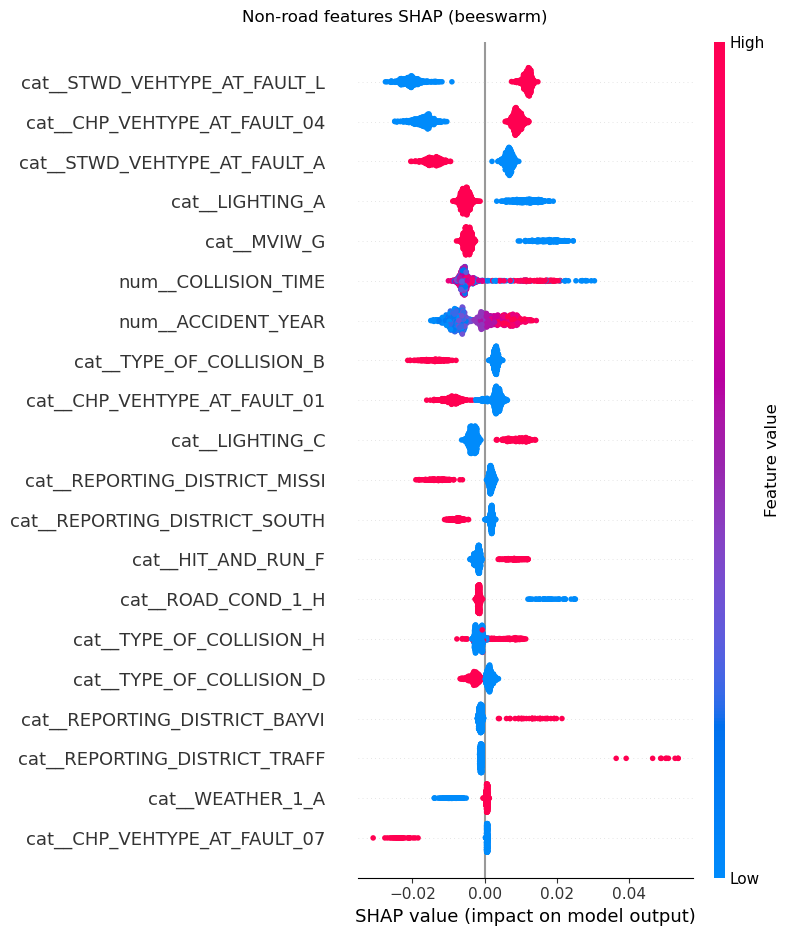

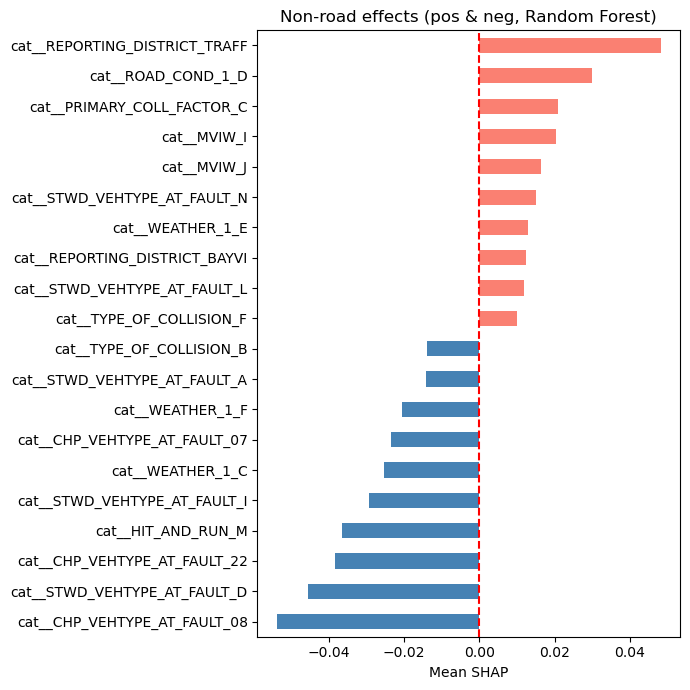

In [43]:
# Non-road features beeswarm
shap.summary_plot(
    shap_array[:, other_mask],
    X_enc[:, other_mask],
    feature_names=feature_names[other_mask],
    max_display=20,
    show=False,
)

fig = plt.gcf()
fig.suptitle("Non-road features SHAP (beeswarm)")
plt.tight_layout()

fig.savefig("figures/nonroad_shap_beeswarm.png", dpi=300, bbox_inches="tight")

plt.show()   
plt.close(fig)


# Split non-road into dummies (cat__) and numeric/others
nonroad_names = feature_names[other_mask]
nonroad_shap = shap_array[:, other_mask]
nonroad_feat = X_enc[:, other_mask]

dummy_idx = [i for i, n in enumerate(nonroad_names) if n.startswith("cat__")]
num_idx   = [i for i, n in enumerate(nonroad_names) if not n.startswith("cat__")]

# Conditional mean SHAP for dummies when value == 1
present_mean = []
present_names = []
for j in dummy_idx:
    m = nonroad_feat[:, j] == 1
    present_names.append(nonroad_names[j])
    present_mean.append(nonroad_shap[m, j].mean() if m.any() else 0.0)
cond_series = pd.Series(present_mean, index=present_names)

# Overall mean SHAP for numeric/other features
num_series = pd.Series(
    nonroad_shap[:, num_idx].mean(axis=0),
    index=[nonroad_names[j] for j in num_idx],
)

# Combine and plot
combined = pd.concat([cond_series, num_series])
top_pos = combined.sort_values().tail(10)
top_neg = combined.sort_values().head(10)
both = pd.concat([top_neg, top_pos])

colors = ["steelblue" if v < 0 else "salmon" for v in both]
both.plot(kind="barh", figsize=(7,7), color=colors)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Mean SHAP")
plt.title("Non-road effects (pos & neg, Random Forest)")
plt.tight_layout()
plt.savefig("figures/nonroad_effects_SHAP_bar.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()




## Major Observations from the Modelling
The Random Forest model outperformed the other two models in predicting crash severity in San Francisco bike crashes, especially in identifying KSI (Killed or Severely Injured) crashes. The SHAP analysis revealed that certain roads and crash characteristics significantly influence the likelihood of severe injuries. 

As was observed in the clustering analysis, specific roads such as Dolores Street and Bayshore Boulevard are associated with higher severity crashes. These associations were confirmed by the SHAP beeswarm plot for road features, which showed that crashes on these roads have a higher likelihood of being KSI crashes (positive SHAP value). 

Additionally, non-road features such as vehicle type at fault, lighting conditions, and type of collision also play a significant role in determining crash severity. Specifically, it was found that crashes in construction or repair zones, those involving a primary collision factor that is not the driver, crashes involving overturning and crashes where the cyclist was at fault have a higher likelihood of being KSI crashes.

These insights, together with what was observed in the EDA and Clustering Analyses, can inform targeted interventions to further improve cyclist safety in San Francisco.